In [1]:
from pathlib import Path
import sys

home_path = str(Path.cwd().parent)
sys.path.append(home_path)
sys.path.append('/eos/project/c/collimation-team/software/lossmaps')

In [2]:
from global_package.tool import Tool

In [3]:
tool = Tool(spark)
tool.show()

In [40]:
fig, i = tool.a_little_normalised_losses_figure(tool.valid_peaks)
print(i)

9.77602756650948


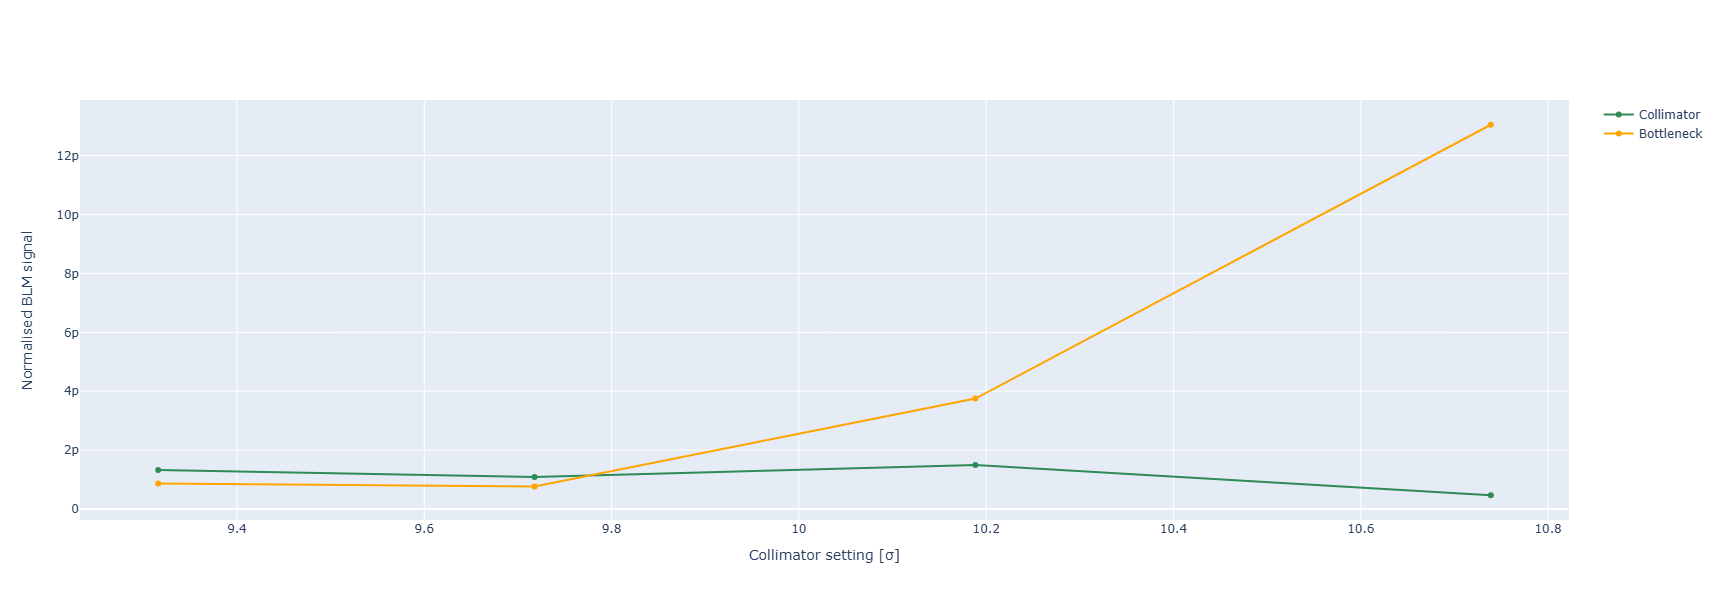

In [41]:
fig

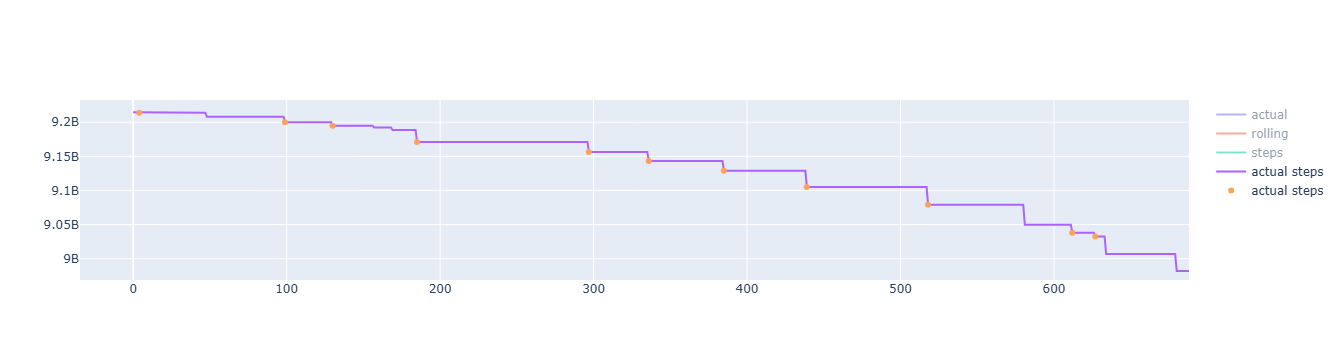

In [12]:
import plotly.graph_objects as go

fig = go.Figure()
t=tool.bunches.bunch_df['time'].values[0]

fig.add_trace(go.Scatter(x=tool.bunches.bunch_df['time']-t, y=tool.bunches.bunch_df[tool.bunches.bunch], name='actual'))
fig.add_trace(go.Scatter(x=tool.bunches.bunch_df['time']-t, y=tool.bunches.bunch_df[tool.bunches.bunch].rolling(window=6).mean(), name='rolling'))
fig.add_trace(go.Scatter(x=tool.bunches.bunch_df['time']-t, y=tool.bunches.smoothed_bunch_intensity, name='steps'))
fig.add_trace(go.Scatter(x=tool.bunches.bunch_df['time']-t, y=tool.bunches.steps, name='actual steps'))
fig.add_trace(go.Scatter(x=tool.bunches.protons_lost.time-t, y=tool.bunches.steps[tool.bunches.protons_lost.peaks], mode='markers'))

fig.show()

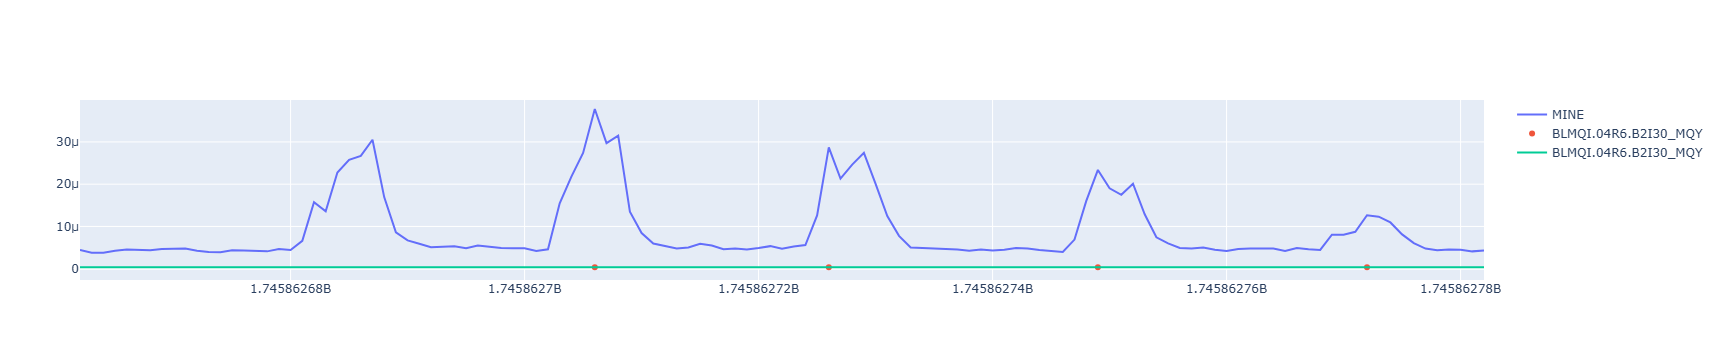

In [10]:
import plotly.graph_objects as go

fig = go.Figure()

BOTTLENECK = 'BLMQI.04R6.B2I30_MQY'

fig.add_trace(go.Scatter(x=tool.blms.blm_mqx_df['time'], y=tool.blms.blm_mqx_df['BLMTL.06R7.B2I10_TCP.C6R7.B2'], name='MINE'))
fig.add_trace(go.Scatter(x=tool.blms.blm_mqx_df['time'].values[tool.collimators.peaks.peaks.values], y=tool.blms.blm_mqx_df[BOTTLENECK].values[tool.collimators.peaks.peaks.values], name=BOTTLENECK, mode='markers'))
fig.add_trace(go.Scatter(x=tool.blms.blm_mqx_df['time'], y=tool.blms.blm_mqx_df[BOTTLENECK], name=BOTTLENECK))

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=tool.blms.blm_mqx_df['time'], y=tool.blms.blm_mqx_df['BLMTL.06R7.B2I10_TCP.C6R7.B2']/tool.blms.blm_mqx_df['BLMTL.06R7.B2I10_TCP.C6R7.B2'].max(), name='BLMTL.06R7.B2I10_TCP.C6R7.B2'))
fig.add_trace(go.Scatter(x=tool.blms.blm_mqx_df['time'], y=tool.blms.blm_mqx_df['BLMQI.06L8.B2I10_MQML']/tool.blms.blm_mqx_df['BLMQI.06L8.B2I10_MQML'].max(), name='BLMQI.06L8.B2I10_MQML'))

fig.show()